In [1]:
%reset -f
from pythonrc import *
from nice_plots import *

In [2]:
time_step = 1.0/100.0

actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for actuator in actuators:
    actuator.extra_attributes["rate_limit"] = 1.0
    # actuator.extra_attributes.pop("reference_angle", None)


time_step = 0.1
allocator_types = [
    skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
    skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
    skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
    skadipy.allocator.reference_filters.MinimumMagnitude,
]
gamma = [0.1, 0.1, 0.1]
mu = [0.1, 0.1, 0.1]
rho = [0.1, 0.1, 0.1]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.99, 0.0, None]

list_kwargs = [
    {"gamma": gamma[0], "mu": mu[0], "rho": rho[0], "zeta": zeta[0], "lambda_": lambda_p[0]},
    {"gamma": gamma[1], "mu": mu[1], "rho": rho[1], "zeta": zeta[1], "lambda_": 0.5},
    {"gamma": gamma[1], "mu": mu[1], "rho": rho[1], "zeta": zeta[1], "lambda_": lambda_p[1]},
    {"gamma": gamma[2], "mu": mu[2], "rho": rho[2], "zeta": zeta[2]},
]

table = dict_to_table({
    "Run": range(1, len(gamma) + 1),
    r"Frequency": [f"{1.0/time_step} Hz" for i in range(len(gamma))],
    r"$\gamma$" : gamma,
    r"$\mu$" : mu,
    r"$\rho$" : rho,
    r"$\zeta$" : zeta,
    r"$\lambda_i$" : lambda_p,
    r"$\bar{\Omega}_1$" : [actuators[0].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_2$" : [actuators[1].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_3$" : [actuators[2].extra_attributes['rate_limit']] * len(gamma),
})
display(Markdown(table))

| Run | Frequency | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ | $\bar{\Omega}_1$ | $\bar{\Omega}_2$ | $\bar{\Omega}_3$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | 0.99 | 1.0 | 1.0 | 1.0 |
| 2 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | 0.0 | 1.0 | 1.0 | 1.0 |
| 3 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | None | 1.0 | 1.0 | 1.0 |


In [3]:
def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=actuators,
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )

allocators = []
for t, kwargs in zip(allocator_types, list_kwargs):
    allocators.append(
        initialize_allocator(
            t,
            time_step=time_step,
            **kwargs
        )
    )

# for allocator in allocators:
#     allocator._xi = np.array([[0.0, 0.5, -0.0, 0.5, -0.0]]).T
#     allocator._theta = np.array([[-0.5, 0.5]]).T


In [4]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0, 5, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)
# tau_cmd = np.concatenate((np.zeros((int(n/10), 6)), tau_cmd))
d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

results = run_tests2(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)

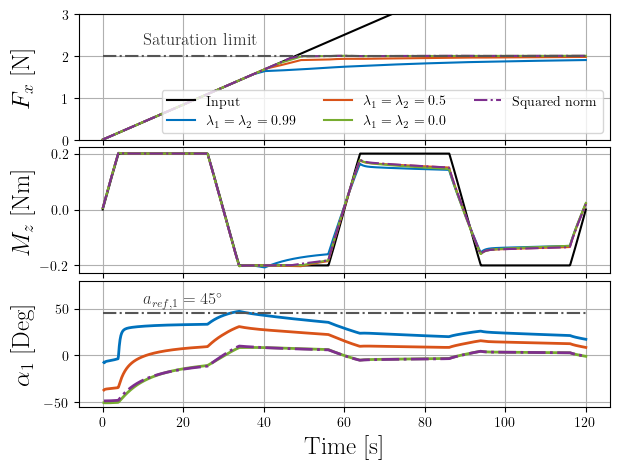

In [5]:
fig, ax = nice_plot_the_thing(
    tau_cmd, results.tau_desired_hist, results.xi_out_hist, dt=time_step
)

labels = []
labels.append(rf"Input")
labels.append(rf"$\lambda_1 = \lambda_2 = {lambda_p[0]}$")
labels.append(rf"$\lambda_1 = \lambda_2 = {0.5}$")
labels.append(rf"$\lambda_1 = \lambda_2 = {lambda_p[1]}$")
labels.append(rf"Squared norm")
ax[0].legend(labels, ncols=3)

ax[0].hlines(2, 0, 120, linestyles="-.", colors="#555555")
ax[0].text(
    10, 2.2, "Saturation limit", color="#333333", va="bottom", ha="left", fontsize=12
)
ax[0].set_ylim(0, 3)

ax[2].hlines(45, 0, 120, linestyles="-.", colors="#555555")
ax[2].text(
    10, 50, r"$a_{ref,1} = 45^\circ$", color="#333333", va="bottom", ha="left", fontsize=12
)
ax[2].set_ylim(-55, 80)
fig.tight_layout(pad=0.0)
fig.align_labels()

fig.savefig("plots/102_the_thing.pdf", bbox_inches='tight')

In [6]:
fig.savefig("plots/102_the_thing.svg", bbox_inches='tight')